In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md

In [3]:
ls

BME_JC_1-Copy1.ipynb  BME_JC_2.ipynb   __pycache__/       sim_Charmm36m.dat
BME_JC_1.html         bme.py           Ree_unscaled/      Structures_LL/
BME_JC_1.ipynb        bme_reweight.py  Ree_unscaled.zip   Structures_LL.zip
BME_JC_2.html         exp.dat          sim_a99SB-UCB.dat


In [4]:
ls ..

a03ws/      a99SB-ILDN-TIP4PD/     a99SB-UCB/      Charmm36m/  Experimental/
a99SBdisp/  a99SBstar-ILDN-TIP3P/  c22star-TIP3P/  Code_BME/


## 1. Data Collection

In [5]:
exp_file = '../Experimental/exp_coup.txt'
sim_file = '../a99SB-UCB/phi-123.dat'

In [6]:
#load your location to file
exp_data=np.loadtxt(exp_file,usecols=(0,1))
exp_data = exp_data.T


In [7]:
#load your location to file
sim_data = np.loadtxt(sim_file, comments='#',usecols=(0,2))
## making groups of 40
sim_data=sim_data[:,1]
sim_data=np.reshape(sim_data,(-1,40)).T
sim_data = sim_data.tolist()

In [8]:
bla = []
for i in range(40):
    if exp_data[1][i] != 0.0:
        bla.append([i+1,[exp_data[1][i],0.42],sim_data[i]])
        

In [9]:
res = []
exp_data = []
sim_data = []
for i in range(len(bla)):
    res.append(bla[i][0])
    exp_data.append(bla[i][1])
    sim_data.append(bla[i][2])

res = np.array(res)
exp_data = np.array(exp_data)
sim_data = np.array(sim_data).T 

In [10]:
# write experimental data
fileout = open('exp.dat','w')
fileout.write('# DATA=JCOUPLINGS PRIOR=GAUSS' + '\n')
for f, b in zip(res, exp_data):
    fileout.write(str(f) + ' ' + str(b[0]) + ' ' + str(b[1]) + '\n')
    
fileout.close()

In [11]:
# write simulation data
fileout = open('sim_a99SB-UCB.dat','w')
#fileout.write('# DATA=JCOUPLINGS PRIOR=GAUSS' + '\n')
for index, value in enumerate(sim_data):
    fileout.write(str(index))
    for i in range(len(sim_data[index])):
        fileout.write(' ' + str(value[i]))
    fileout.write('\n')  
fileout.close()

In [12]:
# define plotting function. 
def plot(f1,f2,wopt=[],w=None,power=None):

    # define figure size
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    # read experimental averages and errors
    exp_data = np.array([[float(x) for x in line.split()[1:]] for line in open(f1) if "#" not in line])
    # read labels
    labels = [line.split()[0] for line in open(f1) if "#" not in line]
    # read back-calculated data 
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(f2) if "#" not in line])
    
    # sort by magnitude to make the plot nicer
    idxs = np.argsort(exp_data[:,0])
    xx = range(len(idxs))
    
    # plot experimental data
    plt.errorbar(xx,exp_data[idxs,0],yerr=exp_data[idxs,1],fmt="o",label="Exp",c='gray')
    # if power is specified, treat as NOE 
    if(power!=None):
        avg = np.average(np.power(calc_data[:,idxs],-power),axis=0,weights=w)
        plt.scatter(xx,np.power(avg,-1./power),label = "MD")
    else:
        plt.scatter(xx,np.average(calc_data[:,idxs],axis=0,weights=w),label = "MD")
    # optionally use weights
    print(len(wopt))
    if(len(wopt)!=0):
        if(power!=None):
            avg = np.average(np.power(calc_data[:,idxs],-power),axis=0,weights=wopt)
            plt.scatter(xx,np.power(avg,-1./power),label = "MD reweighted")
        else:
            plt.scatter(xx,np.average(calc_data[:,idxs],axis=0,weights=wopt),label = "MD, reweighted")
    # set legend
    plt.legend(loc=2)
    # set xticks 
    nl = [labels[i] for i in idxs]
    plt.xticks(xx,nl,rotation=90)
    return labels, exp_data, calc_data


0
36


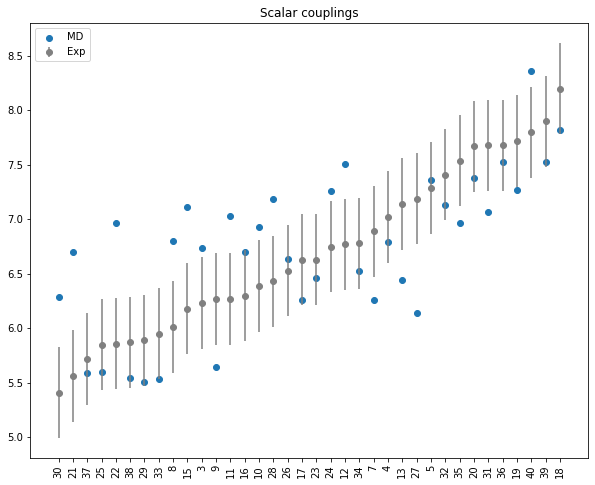

In [13]:
# define name of files                                                                               
exp_couplings = 'exp.dat'
calc_couplings = 'sim_a99SB-UCB.dat'

# plot data
labels, exp_data, calc_data = plot(exp_couplings,calc_couplings)
print (len(labels))
plt.title("Scalar couplings")
plt.show()

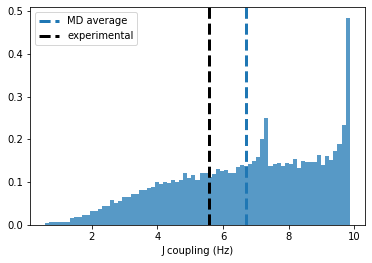

In [14]:
# find index corresponding to the desired coupling
idx = labels.index("21")
# plot the histogram
plt.hist(calc_data[:,idx],bins=75,density=True,alpha=0.75)
# make vertical bar corresponding to the MD average
plt.axvline(np.average(calc_data[:,idx]),label="MD average",ls="--",lw=3)
# make vertical bar corresponding to the MD average
plt.axvline(exp_data[idx,0],c='k',label="experimental",ls="--",lw=3)
plt.xlabel("J coupling (Hz)")
plt.legend()
plt.show()



## 2. BME reweighting ##

We here show how to apply the BME reweighting procedure. Essentially, there are only three fundamental steps:
1. Initialize the class 
2. Load the data. Multiple data can be also loaded (see next example)
3. Optimize

In the example below we match all 36 scalar couplings data described above. Theta is set to 2 for the moment being, the procedure and code to find viable values for theta are shown below.

In [15]:
# import modules
#import sys
#import os

# this is a trick to get the parent directory 
#directory_to_bme = os.getcwd()[:-8]
#sys.path.append(directory_to_bme)

import bme_reweight as bme

# initialize reweighting class                                                                                                                                
rew = bme.Reweight()

# load data                                                                                      
rew.load(exp_couplings,calc_couplings)

# do optimization using theta=2                                                                                                                               
chi2_before,chi2_after, srel = rew.optimize(theta=2)

print ("# CHI2 before minimization:     %8.4f" % (chi2_before))
print ("# CHI2 after minimization:      %8.4f" % (chi2_after))
print ("# Fraction of effective frames: %8.4f" % (np.exp(srel)))


# theta: 2
# CHI2 before minimization:       1.9450
# CHI2 after minimization:        0.0081
# Fraction of effective frames:   0.3521


29978


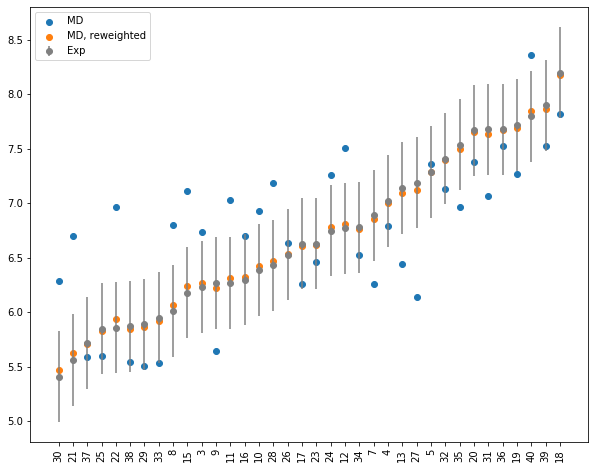

In [16]:
# returns the optimized weights
w_opt = rew.get_weights()

# feed the weights to plotting function
plot(exp_couplings,calc_couplings,wopt=w_opt)
plt.show()

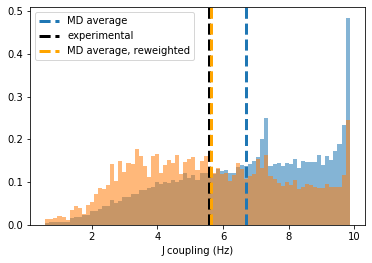

In [17]:
# find index corresponding to the desired coupling
idx = labels.index("21")
# plot the histogram
plt.hist(calc_data[:,idx],bins=75,density=True,alpha=0.55)
# make vertical bar corresponding to the MD average
plt.axvline(np.average(calc_data[:,idx]),label="MD average",ls="--",lw=3)
# make vertical bar corresponding to the MD average
plt.axvline(exp_data[idx,0],c='k',label="experimental",ls="--",lw=3)

# plot the histogram with the new weights
plt.hist(calc_data[:,idx],bins=75,density=True,alpha=0.55,weights=w_opt)
# make vertical bar corresponding to the MD average
plt.axvline(np.average(calc_data[:,idx],weights=w_opt),label="MD average, reweighted",ls="--",lw=3,c='orange')

plt.xlabel("J coupling (Hz)")
plt.legend()
plt.show()

## 4. 𝜃-selection

In [18]:
#this is a trick to get the parent directory 
#directory_to_bme = os.getcwd()[:-8]
#sys.path.append(directory_to_bme)
#import bme_reweight as bme

# define name of files                                                                               
exp_couplings = 'exp.dat'
calc_couplings = 'sim_a99SB-UCB.dat'


# initialize reweighting class                                                                                                                                
rew = bme.Reweight()

# load data                                                                                      
rew.load(exp_couplings,calc_couplings)

# do minimization for different values of theta
thetas= [0.1,0.5,1,2,3,4,5,7.5,10,15,20,40,50,100,500,5000]
results = []
for t in thetas:
    # do the minimization
    chi2_jc_before,chi2_jc_after, srel = rew.optimize(theta=t)
    # calculate agreement with NOE, and write output to a temporary file
    results.append( [np.exp(srel),chi2_jc_before,chi2_jc_after])

# theta: 0.1
# theta: 0.5
# theta: 1
# theta: 2
# theta: 3
# theta: 4
# theta: 5
# theta: 7.5
# theta: 10
# theta: 15
# theta: 20
# theta: 40
# theta: 50
# theta: 100
# theta: 500
# theta: 5000


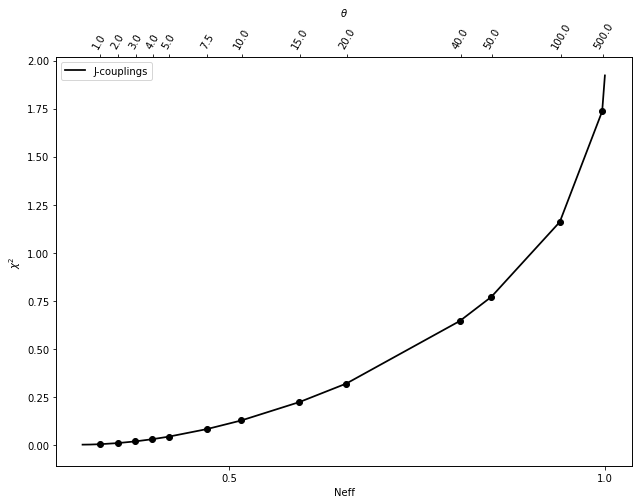

In [19]:
#handling tickers in logspace is a abit painful
from matplotlib.ticker import NullFormatter
from matplotlib import ticker

results = np.array(results)
# define the figure
fig, ax1 = plt.subplots(figsize=(10, 8))
plt.subplots_adjust(left=0.15, right=0.95, top=0.83, bottom=0.12)
# plot j couplings
ax1.plot(results[:,0],results[:,2],label="J-couplings",c='k',lw=1.75)
# plot NOE
#ax1.plot(results[:,0],results[:,4],label="NOE",c='#C1CDCD',ls="--",lw=1.75)
# set tickers
ax1.set_xticks([0.01,0.1,0.2,0.5,1.0])
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%3.1f"))
ax1.xaxis.set_minor_formatter(ticker.NullFormatter())

# now make a new axis just to show the theta values
ax2 = ax1.twiny()
ax2.plot(results[:,0],results[:,2],c='w',lw=0.01)

# draw ticks at selected theta
#sele = [0.1,1,2,5,10,5000]
sele = [1,2,3,4,5,7.5,10,15,20,40,50,100,500]
iis = [thetas.index(s) for s in  sele]
ax2.set_xticks(results[iis,0])
ax2.set_xticklabels(["%.1f"% s for s in sele],rotation=60)
#ax1.scatter(results[iis,0],results[iis,4],c='#C1CDCD')
ax1.scatter(results[iis,0],results[iis,2],c='k')

ax1.set_xlabel("Neff")
ax2.set_xlabel(r"$\theta$")
ax1.set_ylabel(r"$\chi^2$")
ax1.legend()

In [20]:
# do optimization using theta=10                                                                                                                               
chi2_before,chi2_after, srel = rew.optimize(theta=10)

print ("# CHI2 before minimization:     %8.4f" % (chi2_before))
print ("# CHI2 after minimization:      %8.4f" % (chi2_after))
print ("# Fraction of effective frames: %8.4f" % (np.exp(srel)))

# theta: 10
# CHI2 before minimization:       1.9450
# CHI2 after minimization:        0.1259
# Fraction of effective frames:   0.5164


29978


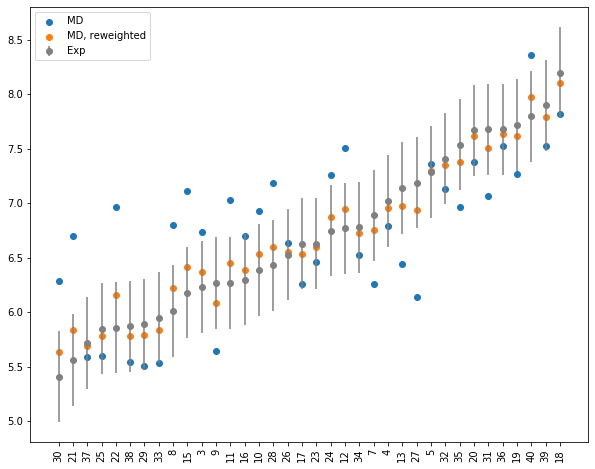

In [21]:
# returns the optimized weights
w_opt = rew.get_weights()

# feed the weights to plotting function
plot(exp_couplings,calc_couplings,wopt=w_opt)
plt.show()

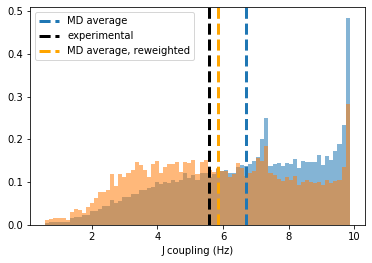

In [22]:
# find index corresponding to the desired coupling
idx = labels.index("21")
# plot the histogram
plt.hist(calc_data[:,idx],bins=75,density=True,alpha=0.55)
# make vertical bar corresponding to the MD average
plt.axvline(np.average(calc_data[:,idx]),label="MD average",ls="--",lw=3)
# make vertical bar corresponding to the MD average
plt.axvline(exp_data[idx,0],c='k',label="experimental",ls="--",lw=3)

# plot the histogram with the new weights
plt.hist(calc_data[:,idx],bins=75,density=True,alpha=0.55,weights=w_opt)
# make vertical bar corresponding to the MD average
plt.axvline(np.average(calc_data[:,idx],weights=w_opt),label="MD average, reweighted",ls="--",lw=3,c='orange')

plt.xlabel("J coupling (Hz)")
plt.legend()
plt.show()

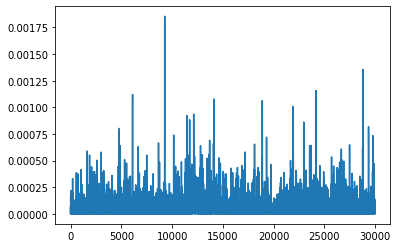

In [23]:
#plt.plot()
plt.plot(w_opt)

## 5. Structural interpretation

In [1]:
main_dir = '/media/argha/Argha_HDD/HiWi_Prof_strodel/jupyter_work/Suman_5_08/deshaw_ss/DEshaw-ab40/'
force_name = 'a99SB-UCB'

force_dir = main_dir + force_name + '/pnas2018b-Ab40-'+ force_name +'-protein'

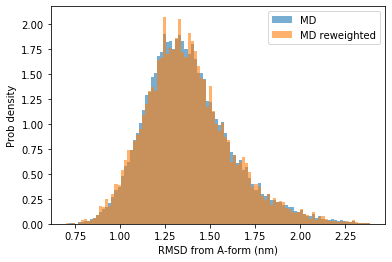

In [24]:
traj = md.load(force_dir + '/traj_concatenated.dcd',top= force_dir + '/ab40-desres.pdb')
ref = md.load(force_dir + '/ab40-desres.pdb')

rmsds = md.rmsd(traj,ref)
plt.hist(rmsds,bins=100,alpha=0.6,density=True,label="MD")
plt.hist(rmsds,bins=100,alpha=0.6,weights= w_opt[1:],density=True,label="MD reweighted")
plt.legend()
plt.xlabel("RMSD from A-form (nm)")
plt.ylabel("Prob density")
plt.show()

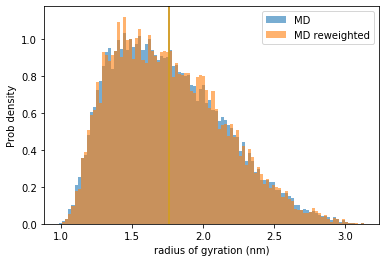

In [25]:
# compute radius of gyration
rg = md.compute_rg(traj)

# make histogram of original simulation
plt.hist(rg,bins=100,alpha=0.6,density=True,label="MD")
# draw vertical line indicating the average
plt.axvline(np.average(rg))
# do the same with the new weights
plt.hist(rg,bins=100,alpha=0.6,weights=w_opt[1:],density=True,label="MD reweighted")
plt.axvline(np.average(rg,weights=w_opt[1:]),c='orange')
# legend and labels
plt.legend()
plt.xlabel("radius of gyration (nm)")
plt.ylabel("Prob density")
plt.show()

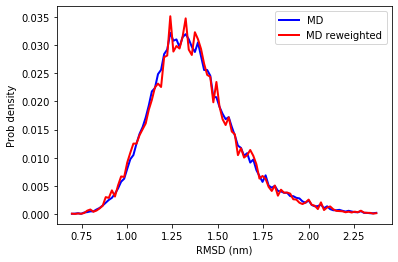

In [26]:
traj = md.load(force_dir + '/traj_concatenated.dcd',top= force_dir + '/ab40-desres.pdb')
ref = md.load(force_dir + '/ab40-desres.pdb')

rmsds = md.rmsd(traj,ref)
bb = np.histogram(rmsds,bins=100,density=True)
cc = np.array(bb)[0]/sum(np.array(bb)[0])

bb1 = np.histogram(rmsds,bins=100,weights= w_opt[1:],density=True,)
cc1 = np.array(bb1)[0]/sum(np.array(bb1)[0])

plt.plot(np.array(bb)[1][0:-1],cc,linestyle='-',color = 'blue',linewidth = 2,label="MD")
plt.plot(np.array(bb1)[1][0:-1],cc1,linestyle='-',color = 'red',linewidth = 2, label="MD reweighted")

plt.legend()
plt.xlabel("RMSD (nm)")
plt.ylabel("Prob density")
plt.show()

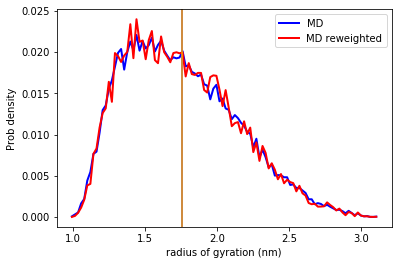

In [27]:
# compute radius of gyration
rg = md.compute_rg(traj)

# make histogram of original simulation
bb = np.histogram(rg,bins=100,density=True)
cc = np.array(bb)[0]/sum(np.array(bb)[0])

plt.plot(np.array(bb)[1][0:-1],cc,linestyle='-',color = 'blue',linewidth = 2,label="MD")
# draw vertical line indicating the average
plt.axvline(np.average(rg), c='blue')

# do the same with the new weights
bb1 = np.histogram(rg,bins=100,weights=w_opt[1:],density=True)
cc1 = np.array(bb1)[0]/sum(np.array(bb1)[0])

plt.plot(np.array(bb1)[1][0:-1],cc1,linestyle='-',color = 'red',linewidth = 2, label="MD reweighted")
plt.axvline(np.average(rg,weights=w_opt[1:]),c='orange')
# legend and labels
plt.legend()
plt.xlabel("radius of gyration (nm)")
plt.ylabel("Prob density")
plt.show()

## Reweighted MD (𝜃=10)

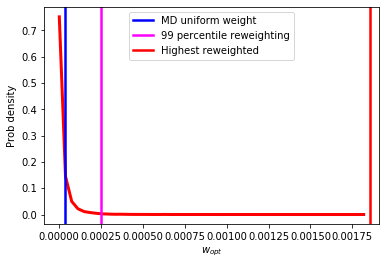

In [28]:
bb = np.histogram(w_opt,bins=50,density=True)
cc = np.array(bb)[0]/sum(np.array(bb)[0])

plt.plot(np.array(bb)[1][0:-1],cc,linestyle='-',color = 'red',linewidth = 3)
plt.xlabel("$w_{opt}$")
plt.ylabel("Prob density")

plt.axvline(1/len(w_opt), c = 'blue',linewidth = 2.5,label="MD uniform weight" )
plt.axvline(np.percentile(w_opt,99),c='magenta',linewidth = 2.5, label="99 percentile reweighting" )
plt.axvline(np.max(w_opt),c='red',linewidth = 2.5, label="Highest reweighted " )

plt.legend()
plt.show()

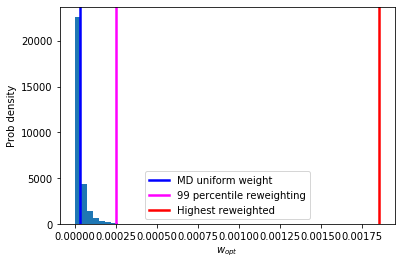

In [29]:
counts, bins = np.histogram(w_opt, bins = 50)
plt.hist(bins[:-1], bins, weights=counts)

plt.axvline(1/len(w_opt), c = 'blue',linewidth = 2.5,label="MD uniform weight" )
plt.axvline(np.percentile(w_opt,99),c='magenta',linewidth = 2.5, label="99 percentile reweighting" )
plt.axvline(np.max(w_opt),c='red',linewidth = 2.5, label="Highest reweighted " )

plt.xlabel("$w_{opt}$")
plt.ylabel("Prob density")
plt.legend()
plt.show()

#### In the above plots, the blue line marks the Uniform weight from MD (before applying reweighting). On reweighting, $72\%$ of the structures lie on the left of the blue line i.e. their weight decreases from the uniform MD weight. Accordingly, for 28% of the structures, their weight increases.  

#### The orange line marks the 99 percentile value i.e. to the left of it, 99% of the structures, having small individual weights, are located. To the right, the remaining 1% of the structure, which was reweighted to higher individual weights are located.  

### Next, we choose 100 random samples in a weighted manner

In [52]:
# choose 100 samples
#ff = np.random.choice(len(w_opt),size=100,p=w_opt,replace=False)

# save the frames to trajectory
#traj[ff].save("new_trajectory.dcd")

#### We then show the histogram of the weights of these 100 randomly selected structures. Selection being done in a weighted manner, the weights follow the same distribution as above.

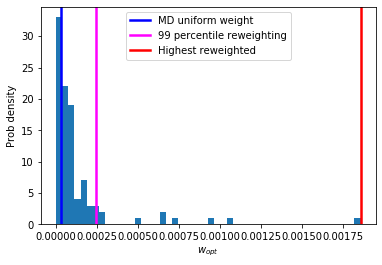

In [77]:
counts, bins = np.histogram(w_opt[ff], bins = 50)
plt.hist(bins[:-1], bins, weights=counts)

plt.axvline(1/len(w_opt), c = 'blue',linewidth = 2.5,label="MD uniform weight" )
plt.axvline(np.percentile(w_opt,99),c='magenta',linewidth = 2.5, label="99 percentile reweighting" )
plt.axvline(np.max(w_opt),c='red',linewidth = 2.5, label="Highest reweighted " )
plt.xlabel("$w_{opt}$")
plt.ylabel("Prob density")
plt.legend()
plt.show()

#### So, should I just extract these 100 structures selected randomly above? Or, take more samples from the tail region (say more structures in the right of 80 or 90 percentile mark?)  i.e. take more samples which have received largest weights after reweighting procedure (sort of importance sampling in the tail region). What would be more interesting for our study? 

## Extract Structures

#### Good Structures

In [46]:
bla = sorted( [(x,i) for (i,x) in enumerate(w_opt)], reverse=True )[:50]
bla = [(i,x) for (x,i) in bla]
bla1 = np.array(bla)[:,0]
bla1 = [int(i) for i in bla1]

In [34]:
#fmt = '%d', '%e'
#np.savetxt('good_a99SB-UCB.dat', bla, fmt = fmt, delimiter='\t')

In [36]:
# save the frames to trajectory
#traj[bla1].save("good_a99SB-UCB.dcd")

#### Good Ree_unscaled

In [47]:
topology = traj.topology
back = topology.select("name CA") #select all atoms
atom_pair = [[back[0],back[-1]]]

In [48]:
end_unscaled = []
for index in bla1:
    #print(index)
    end_end = md.compute_distances(traj[index], atom_pair, periodic=False, opt= False)[0][0]
    end_unscaled.append(end_end)

In [49]:
bla = [(value[0],value[1]) for value in zip(bla1,end_unscaled)]
fmt = '%d', '%1.3f'
np.savetxt('Ree_good_a99SB-UCB.dat', bla, fmt = fmt, delimiter='\t')

#### Bad Structures

In [50]:
bla = sorted( [(x,i) for (i,x) in enumerate(w_opt)], reverse=False )[:50]
bla = [(i,x) for (x,i) in bla]
bla1 = np.array(bla)[:,0]
bla1 = [int(i) for i in bla1]

In [38]:
#fmt = '%d', '%e'
#np.savetxt('bad_a99SB-UCB.dat', bla, fmt = fmt, delimiter='\t')

In [39]:
# save the frames to trajectory
#traj[bla1].save("bad_a99SB-UCB.dcd")

#### Bad Ree_unscaled 

In [51]:
end_unscaled = []
for index in bla1:
    #print(index)
    end_end = md.compute_distances(traj[index], atom_pair, periodic=False, opt= True)[0][0]
    end_unscaled.append(end_end)

In [52]:
bla = [(value[0],value[1]) for value in zip(bla1,end_unscaled)]
fmt = '%d', '%1.3f'
np.savetxt('Ree_bad_a99SB-UCB.dat', bla, fmt = fmt, delimiter='\t')